<a href="https://colab.research.google.com/github/Vedant2100/w26/blob/main/hw3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Q1. Setup

 Normalization using train data mean and train data standard dev to both training and test data.

In [11]:
from datasets import load_dataset
import numpy as np
import time
import matplotlib.pyplot as plt
from tqdm import tqdm

dataset = load_dataset("ylecun/mnist")

def format_data(split, mean=None, std=None):
    images = np.array([np.array(img).flatten() for img in split["image"]])
    if mean is None or std is None:
        mean = np.mean(images, axis=0)
        std = np.std(images, axis=0)
    std_copy = std.copy()
    std_copy[std_copy == 0] = 1.0
    X = (images - mean) / std_copy
    y = np.array(split["label"])
    return X, y, mean, std

# Q2. MNIST models with diff k and p

## 2.1 No dropout (p = 0.0)
 I think there might be a typo in the question, because no dropout regularisation would correpsond to p = 0, not p = 1 as mention in the question. With p = 0.0, as k (the number of units )increases, the training accuracy and test accuracy both improve. At no k in the current set, the training accuracy has become 100%. I tried out a higher learning rate than the default value of 0.001, 0.01 and the training accuracy did get cloxer to 100% but still not, so increase number of epochs too.

In [12]:
X_train, y_train, train_mean, train_std = format_data(dataset["train"])
X_test, y_test, _, _ = format_data(dataset["test"], train_mean, train_std)
print(f"Shape of y_train: {y_train.shape}")
print(f"Shape of y_test: {y_test.shape}")

Shape of y_train: (60000,)
Shape of y_test: (10000,)


In [13]:
np.random.seed(0)
idxs = []
for c in range(10):
    class_idxs = np.where(y_train == c)[0]
    chosen = np.random.choice(class_idxs, size=1000, replace=True)
    idxs.append(chosen)
idxs = np.concatenate(idxs)
np.random.shuffle(idxs)
X_train = X_train[idxs]
y_train = y_train[idxs]

In [14]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class shallowNN(nn.Module):
    def __init__(self, k = 1, p = 0.1):
        super(shallowNN, self).__init__()
        self.fc1 = nn.Linear(784, k)
        nn.init.kaiming_normal_(self.fc1.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc1.bias)
        self.dropout = nn.Dropout(p)
        self.fc2 = nn.Linear(k, 10)
        nn.init.kaiming_normal_(self.fc2.weight, nonlinearity='relu')
        nn.init.zeros_(self.fc2.bias)
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x

model = shallowNN()

In [15]:
import matplotlib.pyplot as plt
import tqdm


def init_weights(m):
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
        if m.bias is not None:
            nn.init.zeros_(m.bias)

def train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs = 80, lr = 0.001):
    model = shallowNN(k=k, p=p)
    model.apply(init_weights)
    optimizer = torch.optim.Adam(model.parameters(), lr = lr)
    train_acc = {}
    test_acc = {}
    loss_hist = {}
    for epoch in tqdm.tqdm(range(epochs)):
        model.train()
        inputs = torch.tensor(X_train, dtype=torch.float32)
        labels = torch.tensor(y_train, dtype=torch.long)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = F.cross_entropy(outputs, labels)
        loss_hist[(k, p, epoch)] = loss.item()
        loss.backward()
        optimizer.step()
        with torch.no_grad():
            model.eval()
            train_acc[(k, p, epoch)] = (model(inputs).argmax(dim=1) == labels).float().mean().item()
            test_outputs = model(torch.tensor(X_test, dtype=torch.float32))
            test_acc[(k, p, epoch)] = (test_outputs.argmax(dim=1) == torch.tensor(y_test, dtype=torch.long)).float().mean().item()
            model.train()
    return train_acc, test_acc, loss_hist

### LR = 0.001 (default)

100%|██████████| 80/80 [00:07<00:00, 10.39it/s]


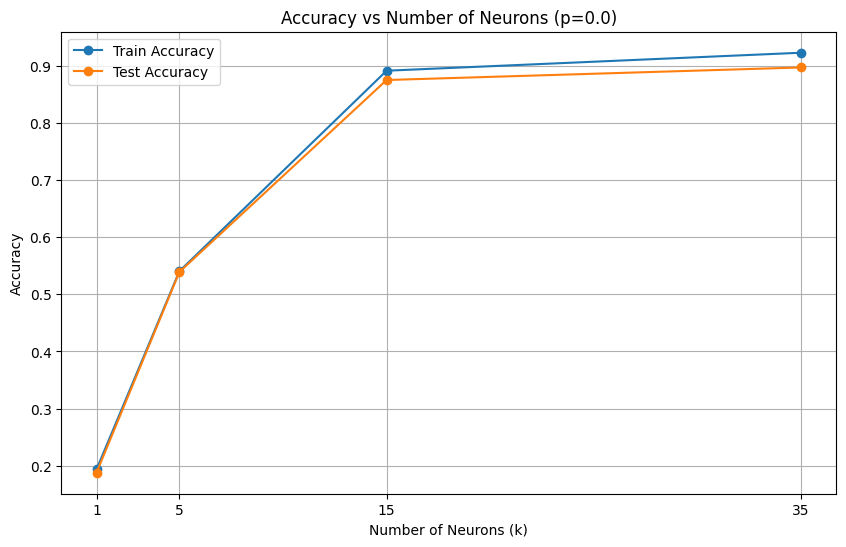


Final train accuracy k = 35, p = 0.0: 0.9230999946594238

Final test accuracy k = 35, p = 0.0: 0.8973000049591064


In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [0.0]
lr = 0.001
epochs = 80
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {overall_train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {overall_test_acc[(k, p, epochs-1)]}")


### LR = 0.01

100%|██████████| 80/80 [00:07<00:00, 10.66it/s]


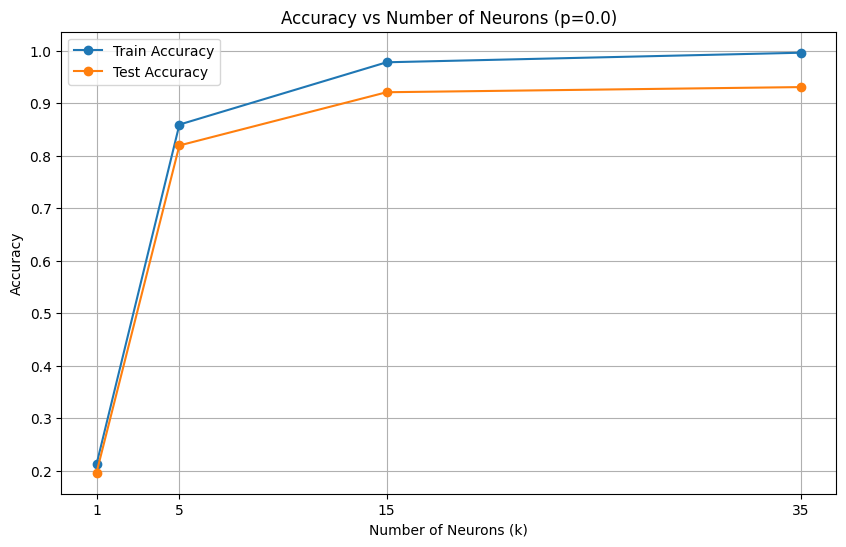


Final train accuracy k = 35, p = 0.0: 0.9958999752998352

Final test accuracy k = 35, p = 0.0: 0.9304999709129333


In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [0.0]
epochs = 80
lr = 0.01
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {overall_train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {overall_test_acc[(k, p, epochs-1)]}")


100%|██████████| 200/200 [00:20<00:00,  9.85it/s]


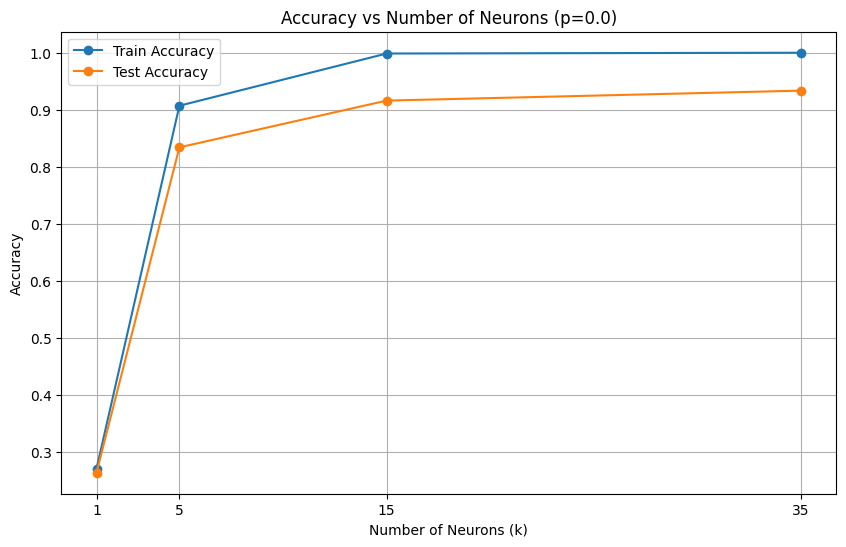


Final train accuracy k = 35, p = 0.0: 1.0

Final test accuracy k = 35, p = 0.0: 0.9334999918937683


In [ ]:
torch.manual_seed(0)
kvals = [1, 5, 15, 35]
pvals = [0.0]
epochs = 200
lr = 0.01
for p in pvals:
    overall_train_acc = {}
    overall_test_acc = {}
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
    plt.figure(figsize=(10, 6))
    plt.xticks(kvals)
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Train Accuracy')
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o', label='Test Accuracy')
    plt.xlabel('# hidden units (k)')
    plt.ylabel('Accuracy')
    plt.title(f'Accuracy vs # hidden units (p={p})')
    plt.legend()
    plt.grid()
    plt.show()
    print(f"\nFinal train accuracy k = {k}, p = {p}: {overall_train_acc[(k, p, epochs-1)]}")
    print(f"\nFinal test accuracy k = {k}, p = {p}: {overall_test_acc[(k, p, epochs-1)]}")


## 2.2

1. Generally the training accuracy has decreased with increasing p which makes sense as the more neurons are randomly deactivated, the network's capacity to learning data lessens. It dropped a lot in p = 1.0 case where in all neurons were deactivated, then the model didnt learn anything.

2. When p is smaller its generally more difficult to optimize than when p is higher because less number of gradients have to be calculated and backpropagated in this case than higher p.

100%|██████████| 80/80 [00:08<00:00,  9.72it/s]


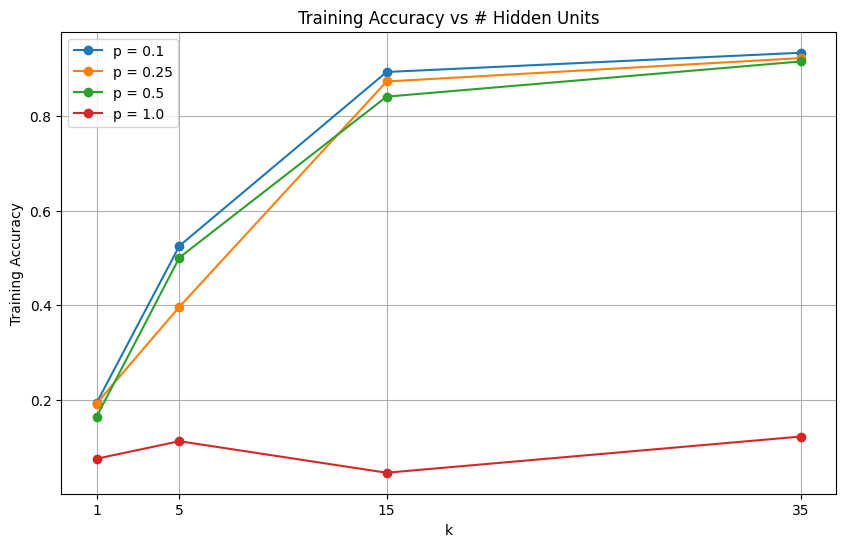

In [19]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)
plt.figure(figsize=(10, 6))
for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()


Currently, none of the networks have reached training accuracy exactly 100% though k = 35, p = 0.1 is very close. In order to determine at what min k among given values will it be achieved, I have to increase the number of epochs.

## 2.2

3. For all values of p (except P = 1.0), a training accuracy of 100% is achieved at k = 35, given sufficient epochs to train.
For p = 1.0, a 100% accuracy will never be achieved as the model won't ever be able to learn the training data.

100%|██████████| 300/300 [00:30<00:00,  9.79it/s]


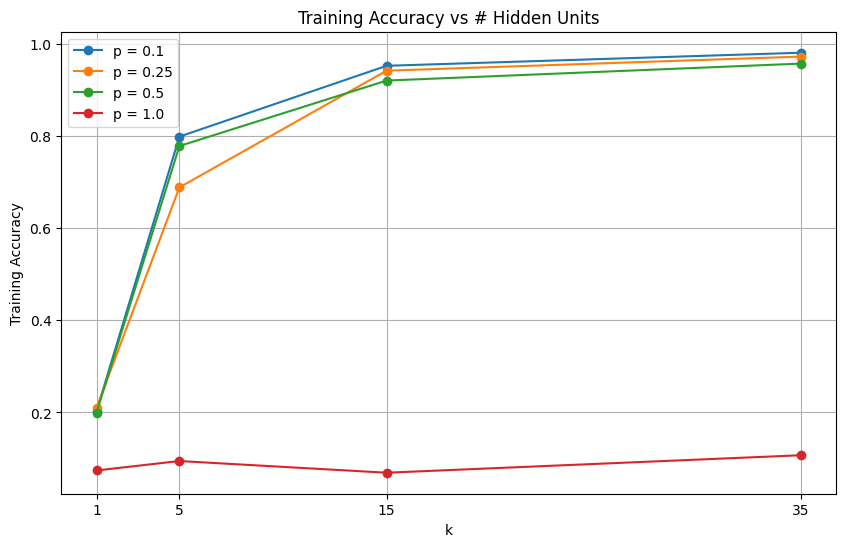

In [ ]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 300
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [overall_train_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Training Accuracy')
plt.title('Training Accuracy vs # Hidden Units')
plt.annotate
plt.legend()
plt.grid()
plt.show()


## 2.3

1. Yes, generally higher the dropout (1-p) or lower the p, the test accuracy is higher (except in the case of p = 0) , it makes sense because the model is more generalizable with more dropout.

2. For k = 35, and p = 0.0, i get highest test accuracy (i.e. no dropout case)

In [21]:
kvals = [1, 5, 15, 35]
pvals = [0.1, 0.25, 0.5, 1.0]
epochs = 80
lr = 0.001
torch.manual_seed(0)
overall_train_acc = {}
overall_test_acc = {}
for p in pvals:
    for k in kvals:
         train_acc, test_acc, loss_hist =  train_model_k_p(X_train, y_train, X_test, y_test, p, k, epochs, lr)
         overall_train_acc.update(train_acc)
         overall_test_acc.update(test_acc)

plt.figure(figsize=(10, 6))

for p in pvals:
    plt.plot(kvals, [overall_test_acc[(k, p, epochs-1)] for k in kvals], marker='o',label=f"p = {p}")
plt.xticks(kvals)
plt.xlabel('k')
plt.ylabel('Test Accuracy')
plt.title('Trest Accuracy vs # Hidden Units')
plt.legend()
plt.grid()
plt.show()

 26%|██▋       | 21/80 [00:02<00:06,  9.80it/s]


KeyboardInterrupt: 